---
# Projecting MLB Position Player Runs Above Replacement (RAR) Through Age 30
---
### Mac Ambler
### 05/24/2023







## Package Imports

First, I imported all the necessary packages for the data cleaning, preprocessing, model generation processes, as well as provided some settings for the pandas and matplotlib packages.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import all necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn import tree

# change pandas display options and mute warnings
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# change matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

---
## Data Cleaning and Preparation

To clean and prepare the data for use in the model, I first read in the .CSV files of the four provided datasets: Appearances, Batting, People, and Prospect Rankings.

In [ ]:
# read in the provided datasets
app_df = pd.read_csv('/content/drive/MyDrive/Orioles_App_Project/Appearances.csv')
bat_df = pd.read_csv('/content/drive/MyDrive/Orioles_App_Project/Batting.csv')
ppl_df = pd.read_csv('/content/drive/MyDrive/Orioles_App_Project/People.csv')
prosp_df = pd.read_csv('/content/drive/MyDrive/Orioles_App_Project/Prospect_Rankings.csv')

Beginning with the Prospect Rankings, I changed some of the variable names to ensure they aligned with those in the other datasets, and then set about creating a metric to encapsulate how highly ranked the players were as prospects to be utilized in the model. The metric I established took each time a player was included in the top 100 prospects and ascribed a certain number of points depending on how highly ranked the player was. For example, a player who was ranked #1 in the prospect rankings was given 100 points, ranked #2 was given 99, and so on. Then, the number of points each player received was averaged across the number of times they appeared in the top 100 rankings. Any players who never appeared in the rankings were given a score of zero. This metric was stored under the variable "prospect_pts".

In [ ]:
# subset the year, rank, and ID columns of dataframe
prosp_df = prosp_df[['year', 'prospect_rank', 'lahman_id']]
# rename column names so they match the other datasets
prosp_df = prosp_df.rename(columns={'year':'yearID', 'lahman_id':'playerID'})

In [ ]:
# create dictionary for ascribing points (1 to 100) to players' prospect ranks
pts_dict = {1:100, 2:99, 3:98, 4:97, 5:96, 6:95, 7:94, 8:93, 9:92, 10:91,
            11:90, 12:89, 13:88, 14:87, 15:86, 16:85, 17:84, 18:83, 19:82, 20:81,
            21:80, 22:79, 23:78, 24:77, 25:76, 26:75, 27:74, 28:73, 29:72, 30:71,
            31:70, 32:69, 33:68, 34:67, 35:66, 36:65, 37:64, 38:63, 39:62, 40:61,
            41:60, 42:59, 43:58, 44:57, 45:56, 46:55, 47:54, 48:53, 49:52, 50:51,
            51:50, 52:49, 53:48, 54:47, 55:46, 56:45, 57:44, 58:43, 59:42, 60:41,
            61:40, 62:39, 63:38, 64:37, 65:36, 66:35, 67:34, 68:33, 69:32, 70:31,
            71:30, 72:29, 73:28, 74:27, 75:26, 76:25, 77:24, 78:23, 79:22, 80:21,
            81:20, 82:19, 83:18, 84:17, 85:16, 86:15, 87:14, 88:13, 89:12, 90:11,
            91:10, 92:9, 93:8, 94:7, 95:6, 96:5, 97:4, 98:3, 99:2, 100:1}

# map this onto the players' ranks and assign this to a new column
prosp_df['prospect_pts'] = prosp_df['prospect_rank'].replace(pts_dict)

In [ ]:
# drop rows with NaN values
prosp_df.dropna(inplace=True)

In [ ]:
# group and subset dataframe, taking the mean of each players' prospect points
prosp_df = prosp_df.groupby('playerID', as_index=False).mean()[['playerID','prospect_pts']]
prosp_df.head(5)

,playerID,prospect_pts
0,abbotje01,15.500000
1,abreubo01,61.333333
2,abreujo02,72.000000
3,aceveju01,46.000000
4,ackledu01,89.500000


Next were the Appearance and Batting datasets, and all that they required was to be filtered so they only contained data from 1994 to the present.

In [ ]:
# filter dataset to only contain info from 1994 on
app_df = app_df[app_df['yearID']>=1994]
app_df.head(5)

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
71822,1994,NYA,AL,abbotji01,24,24.0,0,24.0,24,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
71823,1994,FLO,NL,abbotku01,101,93.0,101,99.0,0,0,0,0,0,99,0,0,0,0,0.0,3.0,1.0
71824,1994,OAK,AL,acrema01,34,0.0,2,34.0,34,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
71825,1994,MIN,AL,aguilri01,44,0.0,0,44.0,44,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
71826,1994,OAK,AL,aldremi01,76,39.0,76,60.0,0,0,27,0,0,0,21,0,15,35,1.0,28.0,2.0


In [ ]:
# filter dataset to only contain info from 1994 on
bat_df = bat_df[bat_df['yearID']>=1994]
bat_df.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
71871,abbotji01,1994,1,NYA,AL,24,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
71872,abbotku01,1994,1,FLO,NL,101,345,41,86,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0
71873,acrema01,1994,1,OAK,AL,34,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
71874,aguilri01,1994,1,MIN,AL,44,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
71875,aldremi01,1994,1,OAK,AL,76,178,23,43,5,0,4,18.0,2.0,0.0,20,35.0,1.0,0.0,0.0,3.0,2.0


Lastly, the People dataset was filtered to only contain players included in the batting dataset, and a value of 1 was added to the birth years of players born after July 1st, since I only needed to know the age they were prior to this date.

In [ ]:
# filter dataset to only include those players in the batting dataset
ppl_df = ppl_df[ppl_df['playerID'].isin(list(bat_df['playerID']))]
# add 1 to a players birth year if they were born after July 1st
ppl_df['birthYear'][ppl_df['birthMonth'] >= 7] += 1
ppl_df.head(5)

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1982.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,NaN,NaN,NaN,David,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
4,abadan01,1973.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,NaN,NaN,NaN,Andy,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01
5,abadfe01,1986.0,12.0,17.0,D.R.,La Romana,La Romana,NaN,NaN,NaN,NaN,NaN,NaN,Fernando,Abad,Fernando Antonio,220.0,73.0,L,L,2010-07-28,2017-10-01,abadf001,abadfe01
13,abbotje01,1973.0,8.0,17.0,USA,GA,Atlanta,NaN,NaN,NaN,NaN,NaN,NaN,Jeff,Abbott,Jeffrey William,190.0,74.0,R,L,1997-06-10,2001-09-29,abboj002,abbotje01
14,abbotji01,1968.0,9.0,19.0,USA,MI,Flint,NaN,NaN,NaN,NaN,NaN,NaN,Jim,Abbott,James Anthony,200.0,75.0,L,L,1989-04-08,1999-07-21,abboj001,abbotji01


---
## Calculate Offensive Metrics

The first step toward calculating the Runs Above Replacement produced by each player was to capture their offensive production by calculating Offensive Runs Above Average (ORAA). The calculation required the following statistics: OBP, SLG, OPS, and PA. Each of these was calculated using the provided batting data.

In [ ]:
# calculate on-base percentage and replace any NaNs with 0
bat_df['OBP'] = (bat_df['H'] + bat_df['BB'] + bat_df['HBP'])/(bat_df['AB'] + bat_df['BB'] + bat_df['HBP'] + bat_df['SF'])
bat_df['OBP'] = bat_df['OBP'].fillna(0)

In [ ]:
# calculate the number of singles
bat_df['1B'] = bat_df['H'] - bat_df['2B'] - bat_df['3B'] - bat_df['HR']
# calculate slugging percentage and replace any NaNs with 0
bat_df['SLG'] = (bat_df['1B'] + 2*bat_df['2B'] + 3*bat_df['3B'] + 4*bat_df['HR'])/bat_df['AB']
bat_df['SLG'] = bat_df['SLG'].fillna(0)

In [ ]:
# calculate on-base plus slugging
bat_df['OPS'] = bat_df['OBP'] + bat_df['SLG']

In [ ]:
# calculate the number of plate appearances and type cast them to integers
bat_df['PA'] = bat_df['AB'] + bat_df['BB'] + bat_df['HBP'] + bat_df['SF'] + bat_df['SH']
bat_df['PA'] = bat_df['PA'].astype(int)
# filter the dataframe to only players with at least one PA
bat_df = bat_df[bat_df['PA'] > 0]

Additionally, ORAA requires that one calculate the league average OPS in a given year. Per the project instructions, the American League average was used so as to avoid any bias from pitchers with poor hitting stats.

In [ ]:
# for each year from 1994-2017, calculate the average OPS in the AL and store it in the batting dataframe
bat_df['yearAVG_OPS'] = 0
for year in range(1994,2018):
  yearAVG = np.mean(bat_df['OPS'][(bat_df['yearID']==year) & (bat_df['lgID'] == 'AL') & (bat_df['PA'] > 0)])
  bat_df['yearAVG_OPS'][bat_df['yearID']==year] = yearAVG
  print(year, 'AL Avg. OPS =', np.round(yearAVG, 3))

1994 AL Avg. OPS = 0.699
1995 AL Avg. OPS = 0.682
1996 AL Avg. OPS = 0.713
1997 AL Avg. OPS = 0.613
1998 AL Avg. OPS = 0.584
1999 AL Avg. OPS = 0.623
2000 AL Avg. OPS = 0.624
2001 AL Avg. OPS = 0.59
2002 AL Avg. OPS = 0.59
2003 AL Avg. OPS = 0.598
2004 AL Avg. OPS = 0.57
2005 AL Avg. OPS = 0.591
2006 AL Avg. OPS = 0.601
2007 AL Avg. OPS = 0.634
2008 AL Avg. OPS = 0.605
2009 AL Avg. OPS = 0.574
2010 AL Avg. OPS = 0.563
2011 AL Avg. OPS = 0.583
2012 AL Avg. OPS = 0.54
2013 AL Avg. OPS = 0.541
2014 AL Avg. OPS = 0.534
2015 AL Avg. OPS = 0.581
2016 AL Avg. OPS = 0.565
2017 AL Avg. OPS = 0.593


Finally, PA, OPS, and league-average OPS were used to calculate the values for ORAA and these were stored in the batting dataframe.

In [ ]:
# compute ORAA using PA, OPS, and AL average OPS
bat_df['ORAA'] = bat_df['PA']*(bat_df['OPS']-bat_df['yearAVG_OPS'])/3.2135
bat_df.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OBP,1B,SLG,OPS,PA,yearAVG_OPS,ORAA
71872,abbotku01,1994,1,FLO,NL,101,345,41,86,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,0.290761,57,0.394203,0.684964,371,0.698922,-1.611479
71875,aldremi01,1994,1,OAK,AL,76,178,23,43,5,0,4,18.0,2.0,0.0,20,35.0,1.0,0.0,0.0,3.0,2.0,0.313433,34,0.337079,0.650511,201,0.698922,-3.028008
71876,alicelu01,1994,1,SLN,NL,88,205,32,57,12,5,5,29.0,4.0,5.0,30,38.0,4.0,3.0,1.0,3.0,1.0,0.373444,35,0.458537,0.831981,242,0.698922,10.020284
71877,alomaro01,1994,1,TOR,AL,107,392,78,120,25,4,8,38.0,19.0,8.0,51,41.0,2.0,2.0,7.0,3.0,14.0,0.386161,83,0.451531,0.837691,455,0.698922,19.648378
71878,alomasa02,1994,1,CLE,AL,80,292,44,84,15,1,14,43.0,8.0,4.0,25,31.0,2.0,2.0,0.0,1.0,7.0,0.346875,54,0.489726,0.836601,320,0.698922,13.710068


---
## Calculate Defensive Metrics

To calculate the other half of the RAR equation, Defensive Runs Above Average (DRAA), I first filtered out all players that only ever appeared as a pitcher.
Then, I estimated the number of games started at each position by dividing the number of games listed at each position by the total number of games and then multiplying it by the number of games started.

In [ ]:
# filter out all players who only made appearances as a pitcher
app_df = app_df[(app_df['G_all'] - app_df['G_p']) > 0]

In [ ]:
# for each position, estimate the number of games started at each position
# assign this estimation to a new variable
app_df['GS_p'] = (app_df['G_p']/app_df['G_all'])*app_df['GS']
app_df['GS_c'] = (app_df['G_c']/app_df['G_all'])*app_df['GS']
app_df['GS_1b'] = (app_df['G_1b']/app_df['G_all'])*app_df['GS']
app_df['GS_2b'] = (app_df['G_2b']/app_df['G_all'])*app_df['GS']
app_df['GS_3b'] = (app_df['G_3b']/app_df['G_all'])*app_df['GS']
app_df['GS_ss'] = (app_df['G_ss']/app_df['G_all'])*app_df['GS']
app_df['GS_lf'] = (app_df['G_lf']/app_df['G_all'])*app_df['GS']
app_df['GS_cf'] = (app_df['G_cf']/app_df['G_all'])*app_df['GS']
app_df['GS_rf'] = (app_df['G_rf']/app_df['G_all'])*app_df['GS']
app_df['GS_dh'] = (app_df['G_dh']/app_df['G_all'])*app_df['GS']

Then, to ensure the data didn't have any pitchers that might impact the model, all players who had any estimated number of games started at the pitcher position were filtered out.

In [ ]:
# filter out any players with estimated starts at the pitcher position
app_df = app_df[app_df['GS_p'] == 0]

Lastly, the DRAA was calculated using the estimated number of games started and the Runs Above Average attributed to each position.

In [ ]:
# Compute the DRAA from these estimations and the provided RAA for each position
app_df['DRAA'] = (app_df['GS_c']*9/150) + (app_df['GS_1b']*-9.5/150) + (app_df['GS_2b']*3/150) + (app_df['GS_3b']*2/150) + (app_df['GS_ss']*7/150) + (app_df['GS_lf']*-7/150) + (app_df['GS_cf']*2.5/150) + (app_df['GS_rf']*-7/150) + (app_df['GS_dh']*-15/150)
app_df.head(5)

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,GS_p,GS_c,GS_1b,GS_2b,GS_3b,GS_ss,GS_lf,GS_cf,GS_rf,GS_dh,DRAA
71823,1994,FLO,NL,abbotku01,101,93.0,101,99.0,0,0,0,0,0,99,0,0,0,0,0.0,3.0,1.0,0.0,0.00,0.000000,0.000000,0.0,91.158416,0.000000,0.0,0.000000,0.000000,4.254059
71826,1994,OAK,AL,aldremi01,76,39.0,76,60.0,0,0,27,0,0,0,21,0,15,35,1.0,28.0,2.0,0.0,0.00,13.855263,0.000000,0.0,0.000000,10.776316,0.0,7.697368,0.513158,-1.790921
71827,1994,SLN,NL,alicelu01,88,48.0,88,54.0,0,0,0,53,0,0,2,0,0,2,0.0,37.0,0.0,0.0,0.00,0.000000,28.909091,0.0,0.000000,1.090909,0.0,0.000000,0.000000,0.527273
71828,1994,TOR,AL,alomaro01,107,102.0,107,106.0,0,0,0,106,0,0,0,0,0,0,0.0,5.0,0.0,0.0,0.00,0.000000,101.046729,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2.020935
71829,1994,CLE,AL,alomasa02,80,78.0,80,78.0,0,78,0,0,0,0,0,0,0,0,0.0,2.0,0.0,0.0,76.05,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,4.563000


---
## Calculate Runs Above Replacement

Since ORAA and DRAA had both been calculated it was then possible to compute the players' RAR. At the time, the ORAA and DRAA were housed in different dataframes, so the Batting and Appearances dataframes were left-joined on the player, year, team, and league IDs. Any players in the resulting dataframe that had no listed appearances were removed.

In [ ]:
# left join the batting and appearance datasets
RAR_df = pd.merge(bat_df, app_df, how='left', on=['playerID', 'yearID', 'teamID', 'lgID'])

In [ ]:
# drop any rows with NaN in the G_all column
RAR_df=RAR_df.dropna(subset=['G_all'])
RAR_df.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OBP,1B,SLG,OPS,PA,yearAVG_OPS,ORAA,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,GS_p,GS_c,GS_1b,GS_2b,GS_3b,GS_ss,GS_lf,GS_cf,GS_rf,GS_dh,DRAA
0,abbotku01,1994,1,FLO,NL,101,345,41,86,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,0.290761,57,0.394203,0.684964,371,0.698922,-1.611479,101.0,93.0,101.0,99.0,0.0,0.0,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.00,0.000000,0.000000,0.0,91.158416,0.000000,0.0,0.000000,0.000000,4.254059
1,aldremi01,1994,1,OAK,AL,76,178,23,43,5,0,4,18.0,2.0,0.0,20,35.0,1.0,0.0,0.0,3.0,2.0,0.313433,34,0.337079,0.650511,201,0.698922,-3.028008,76.0,39.0,76.0,60.0,0.0,0.0,27.0,0.0,0.0,0.0,21.0,0.0,15.0,35.0,1.0,28.0,2.0,0.0,0.00,13.855263,0.000000,0.0,0.000000,10.776316,0.0,7.697368,0.513158,-1.790921
2,alicelu01,1994,1,SLN,NL,88,205,32,57,12,5,5,29.0,4.0,5.0,30,38.0,4.0,3.0,1.0,3.0,1.0,0.373444,35,0.458537,0.831981,242,0.698922,10.020284,88.0,48.0,88.0,54.0,0.0,0.0,0.0,53.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,37.0,0.0,0.0,0.00,0.000000,28.909091,0.0,0.000000,1.090909,0.0,0.000000,0.000000,0.527273
3,alomaro01,1994,1,TOR,AL,107,392,78,120,25,4,8,38.0,19.0,8.0,51,41.0,2.0,2.0,7.0,3.0,14.0,0.386161,83,0.451531,0.837691,455,0.698922,19.648378,107.0,102.0,107.0,106.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.00,0.000000,101.046729,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2.020935
4,alomasa02,1994,1,CLE,AL,80,292,44,84,15,1,14,43.0,8.0,4.0,25,31.0,2.0,2.0,0.0,1.0,7.0,0.346875,54,0.489726,0.836601,320,0.698922,13.710068,80.0,78.0,80.0,78.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,76.05,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,4.563000


Then the RAR was calculated by summing the ORAA and DRAA, as well as an additional 20 runs to account for the hypothetical runs that would be produced by a replacement player.

In [ ]:
# use ORAA and DRAA to calculate RAR
RAR_df['RAR'] = RAR_df['ORAA'] + RAR_df['DRAA'] + 20
# set any rows with negative RARs to zero
RAR_df[RAR_df['RAR'] < 0] = 0

The resulting datframe was then subset so that it only included variables that were necessary moving forward.

In [ ]:
# subset dataframe columns to only those I may need going forward
RAR_df = RAR_df[['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'OBP', '1B', 'SLG', 'OPS', 'yearAVG_OPS','PA', 'GS', 'GS_c', 'GS_1b', 'GS_2b', 'GS_3b', 'GS_ss', 'GS_lf', 'GS_cf', 'GS_rf',
       'GS_dh', 'ORAA', 'DRAA', 'RAR']]

---
## Merge with People & Prospect Data

At this point, the Batting and Appearances datasets had been merged, and thus the next step was to add in both the People and Prospect Rankings dataset. Each of these datsets were left-joined on the player IDs, creating one combined dataset. Using the players' birth years and the year ID, player ages were calculated, and then once again the dataframe was subset to only the important variables moving forward.

In [ ]:
# left join RAR dataframe and people dataframe on player ID
combo_df = pd.merge(RAR_df, ppl_df, how='left', on=['playerID'])
# drop row with missing values
combo_df = combo_df.drop(combo_df.index[1324])

In [ ]:
# calculate player ages based on their birth year
combo_df['age'] = combo_df['yearID'] - combo_df['birthYear']
combo_df['age'] = combo_df['age'].astype(int)

In [ ]:
# left join this new dataset and the prospect ranking dataset on player ID
combo_df = pd.merge(combo_df, prosp_df, how='left', on=['playerID'])

In [ ]:
# subset only the important columns for moving forward
combo_df = combo_df[['playerID', 'yearID', 'lgID', 'age', 'weight', 'height', 'bats', 'throws', 'stint', 'G', 'AB', 'R', 'H', '1B',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'OBP', 'SLG', 'OPS', 'yearAVG_OPS', 'PA','GS', 'GS_c', 'GS_1b', 'GS_2b', 'GS_3b', 'GS_ss', 'GS_lf', 'GS_cf', 'GS_rf',
       'GS_dh', 'prospect_pts', 'ORAA', 'DRAA', 'RAR']]

Any players with NaN in place of prospect points were given a value of zero, and the dataframe was filtered to only include players younger than or equal to 30 years old.

In [ ]:
# replace any NaNs in the prospect points column with zero
combo_df['prospect_pts'] = combo_df['prospect_pts'].fillna(0)
# filter the dataframe to player data younger than or equal to 30
combo_df = combo_df[combo_df['age'] <= 30]
combo_df.head(5)

,playerID,yearID,lgID,age,weight,height,bats,throws,stint,G,AB,R,H,1B,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OBP,SLG,OPS,yearAVG_OPS,PA,GS,GS_c,GS_1b,GS_2b,GS_3b,GS_ss,GS_lf,GS_cf,GS_rf,GS_dh,prospect_pts,ORAA,DRAA,RAR
0,abbotku01,1994,NL,25,180.0,71.0,R,R,1,101,345,41,86,57,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,0.290761,0.394203,0.684964,0.698922,371,93.0,0.00,0.0,0.000000,0.0,91.158416,0.000000,0.0,0.000000,0.0,0.0,-1.611479,4.254059,22.642580
2,alicelu01,1994,NL,28,165.0,69.0,B,R,1,88,205,32,57,35,12,5,5,29.0,4.0,5.0,30,38.0,4.0,3.0,1.0,3.0,1.0,0.373444,0.458537,0.831981,0.698922,242,48.0,0.00,0.0,28.909091,0.0,0.000000,1.090909,0.0,0.000000,0.0,0.0,10.020284,0.527273,30.547557
3,alomaro01,1994,AL,26,184.0,72.0,B,R,1,107,392,78,120,83,25,4,8,38.0,19.0,8.0,51,41.0,2.0,2.0,7.0,3.0,14.0,0.386161,0.451531,0.837691,0.698922,455,102.0,0.00,0.0,101.046729,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,19.648378,2.020935,41.669313
4,alomasa02,1994,AL,28,200.0,77.0,R,R,1,80,292,44,84,54,15,1,14,43.0,8.0,4.0,25,31.0,2.0,2.0,0.0,1.0,7.0,0.346875,0.489726,0.836601,0.698922,320,78.0,76.05,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,13.710068,4.563000,38.273068
5,aloumo01,1994,NL,27,185.0,75.0,R,R,1,107,422,81,143,85,31,5,22,78.0,7.0,6.0,42,63.0,10.0,2.0,0.0,5.0,7.0,0.397028,0.592417,0.989445,0.698922,471,106.0,0.00,0.0,0.000000,0.0,0.000000,62.411215,0.0,44.579439,0.0,0.0,42.581669,-4.992897,57.588772


---
## Combine Stats of Players with Multiple Stints

At this point, I had successfully built a single dataset comprised of:

*   Position players
*   Younger than or equal to 30
*   From 1994 to the present

with the following information:

*   Physical measurements (height, weight, handedness)
*   Offensive and defensive metrics
*   Prospect points
*   Calculated Runs Above Replacement

The next step would be to combine the data for players who had multiple stints in a given year. Then I would format the data in such a way as to enable the model I build to best predict the RAR each player has remaining up until their age 30 season. To accomplish this, I planned to make the model features in each of the rows into a cumulative total of the current year and all years prior where appropriate. Additionally, I would create a variable, "RAR_remaining", that represents how much RAR the player produced in the following seasons up until age 30. This way, I would be able to provide the model with information, not only for the current season, but all past years as well to hopefully assist in making the most accurate predictions possible for the remaining production a hitter will produce.

The following code scans the dataset for players who had stints with different teams in the same year, sums the cumulative statistics, recalculates metrics like OPS and RAR, and saves this information as a single row representing all of the players' production in a given year.

In [ ]:
# the player with the most stints in a season has 4
# iterate over numbers from 2 to 4
for stint_num in range(2,5):
  # iterate over the rows where the stint number is equal to the current number
  for index, row in combo_df[combo_df['stint'] == stint_num].iterrows():
    # assign the player's first stint in that year to 'first_stint'
    first_stint = combo_df[(combo_df['playerID']==row['playerID'])&(combo_df['yearID']==row['yearID'])&(combo_df['stint']==1)]

    # check that this first_stint is not  empty
    if not first_stint.empty:
      # create a list of the variables to be summed
      sum_varlist = ['G','AB','R','H','1B','2B','3B','HR','RBI','SB','CS','BB','SO',
                    'IBB','HBP','SH','SF','GIDP','PA','GS','GS_c','GS_1b','GS_2b','GS_3b',
                    'GS_ss','GS_lf','GS_cf','GS_rf','GS_dh','RAR']
      # for each of these variables, sum them across that two stints
      for var in sum_varlist:
        first_stint[var] = first_stint[var] + row[var]

      # calculate the OBP, SLG, OPS, ORAA, DRAA, and RAR for the combined Series
      first_stint['OBP'] = (first_stint['H'] + first_stint['BB'] + first_stint['HBP'])/(first_stint['AB'] + first_stint['BB'] + first_stint['HBP'] + first_stint['SF'])
      first_stint['SLG'] = (first_stint['1B'] + 2*first_stint['2B'] + 3*first_stint['3B'] + 4*first_stint['HR'])/first_stint['AB']
      first_stint['OPS'] = first_stint['OBP'] + first_stint['SLG']
      first_stint['ORAA'] = first_stint['PA']*(first_stint['OPS']-first_stint['yearAVG_OPS'])/3.2135
      first_stint['DRAA'] = (first_stint['GS_c']*9/150) + (first_stint['GS_1b']*-9.5/150) + (first_stint['GS_2b']*3/150) + (first_stint['GS_3b']*2/150) + (first_stint['GS_ss']*7/150) + (first_stint['GS_lf']*-7/150) + (first_stint['GS_cf']*2.5/150) + (first_stint['GS_rf']*-7/150) + (first_stint['GS_dh']*-15/150)
      first_stint['RAR'] = first_stint['ORAA'] + first_stint['DRAA'] + 20
      first_stint[first_stint['RAR'] < 0] = 0

      # set the first stint to this now combined pandas Series
      combo_df[(combo_df['playerID']==row[0])&(combo_df['yearID']==row[1])&(combo_df['stint']==1)] = first_stint
      # drop the row where the stint equals the current stint number
      dropidx = combo_df[(combo_df['playerID']==row[0])&(combo_df['yearID']==row[1])&(combo_df['stint']==stint_num)].index
      combo_df.drop(dropidx , inplace=True)

In [ ]:
combo_df.head(5)

,playerID,yearID,lgID,age,weight,height,bats,throws,stint,G,AB,R,H,1B,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OBP,SLG,OPS,yearAVG_OPS,PA,GS,GS_c,GS_1b,GS_2b,GS_3b,GS_ss,GS_lf,GS_cf,GS_rf,GS_dh,prospect_pts,ORAA,DRAA,RAR
0,abbotku01,1994,NL,25,180.0,71.0,R,R,1,101,345,41,86,57,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,0.290761,0.394203,0.684964,0.698922,371,93.0,0.00,0.0,0.000000,0.0,91.158416,0.000000,0.0,0.000000,0.0,0.0,-1.611479,4.254059,22.642580
2,alicelu01,1994,NL,28,165.0,69.0,B,R,1,88,205,32,57,35,12,5,5,29.0,4.0,5.0,30,38.0,4.0,3.0,1.0,3.0,1.0,0.373444,0.458537,0.831981,0.698922,242,48.0,0.00,0.0,28.909091,0.0,0.000000,1.090909,0.0,0.000000,0.0,0.0,10.020284,0.527273,30.547557
3,alomaro01,1994,AL,26,184.0,72.0,B,R,1,107,392,78,120,83,25,4,8,38.0,19.0,8.0,51,41.0,2.0,2.0,7.0,3.0,14.0,0.386161,0.451531,0.837691,0.698922,455,102.0,0.00,0.0,101.046729,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,19.648378,2.020935,41.669313
4,alomasa02,1994,AL,28,200.0,77.0,R,R,1,80,292,44,84,54,15,1,14,43.0,8.0,4.0,25,31.0,2.0,2.0,0.0,1.0,7.0,0.346875,0.489726,0.836601,0.698922,320,78.0,76.05,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,13.710068,4.563000,38.273068
5,aloumo01,1994,NL,27,185.0,75.0,R,R,1,107,422,81,143,85,31,5,22,78.0,7.0,6.0,42,63.0,10.0,2.0,0.0,5.0,7.0,0.397028,0.592417,0.989445,0.698922,471,106.0,0.00,0.0,0.000000,0.0,0.000000,62.411215,0.0,44.579439,0.0,0.0,42.581669,-4.992897,57.588772


Once the dataframe no longer contained players with multiple stints, the RAR values were still inaccurate as they were predicated on a league average OPS that didn't account for multiple stints. To fix this, I recalculated the average American League OPS for each year and then computed new RAR values once again.

In [ ]:
# for each year from 1994-2017, calculate the average OPS in the AL and store it in the  dataframe
combo_df['yearAVG_OPS'] = 0
for year in range(1994,2018):
  yearAVG = np.mean(combo_df['OPS'][(combo_df['yearID']==year) & (combo_df['lgID'] == 'AL') & (combo_df['PA'] > 0)])
  combo_df['yearAVG_OPS'][combo_df['yearID']==year] = yearAVG
  print(year, 'AL Avg. OPS =', np.round(yearAVG, 3))

1994 AL Avg. OPS = 0.71
1995 AL Avg. OPS = 0.691
1996 AL Avg. OPS = 0.698
1997 AL Avg. OPS = 0.692
1998 AL Avg. OPS = 0.681
1999 AL Avg. OPS = 0.692
2000 AL Avg. OPS = 0.705
2001 AL Avg. OPS = 0.691
2002 AL Avg. OPS = 0.679
2003 AL Avg. OPS = 0.671
2004 AL Avg. OPS = 0.683
2005 AL Avg. OPS = 0.681
2006 AL Avg. OPS = 0.699
2007 AL Avg. OPS = 0.712
2008 AL Avg. OPS = 0.692
2009 AL Avg. OPS = 0.683
2010 AL Avg. OPS = 0.658
2011 AL Avg. OPS = 0.66
2012 AL Avg. OPS = 0.64
2013 AL Avg. OPS = 0.659
2014 AL Avg. OPS = 0.632
2015 AL Avg. OPS = 0.665
2016 AL Avg. OPS = 0.662
2017 AL Avg. OPS = 0.688


In [ ]:
# Recalculate ORAA, and subsequently RAR
combo_df['ORAA'] = combo_df['PA']*(combo_df['OPS']-combo_df['yearAVG_OPS'])/3.2135
combo_df['RAR'] = combo_df['ORAA'] + combo_df['DRAA'] + 20
combo_df[combo_df['RAR'] < 0] = 0

In [ ]:
combo_df.head(5)

,playerID,yearID,lgID,age,weight,height,bats,throws,stint,G,AB,R,H,1B,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OBP,SLG,OPS,yearAVG_OPS,PA,GS,GS_c,GS_1b,GS_2b,GS_3b,GS_ss,GS_lf,GS_cf,GS_rf,GS_dh,prospect_pts,ORAA,DRAA,RAR
0,abbotku01,1994,NL,25,180.0,71.0,R,R,1,101,345,41,86,57,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,0.290761,0.394203,0.684964,0.709646,371,93.0,0.00,0.0,0.000000,0.0,91.158416,0.000000,0.0,0.000000,0.0,0.0,-2.849588,4.254059,21.404472
2,alicelu01,1994,NL,28,165.0,69.0,B,R,1,88,205,32,57,35,12,5,5,29.0,4.0,5.0,30,38.0,4.0,3.0,1.0,3.0,1.0,0.373444,0.458537,0.831981,0.709646,242,48.0,0.00,0.0,28.909091,0.0,0.000000,1.090909,0.0,0.000000,0.0,0.0,9.212677,0.527273,29.739950
3,alomaro01,1994,AL,26,184.0,72.0,B,R,1,107,392,78,120,83,25,4,8,38.0,19.0,8.0,51,41.0,2.0,2.0,7.0,3.0,14.0,0.386161,0.451531,0.837691,0.709646,455,102.0,0.00,0.0,101.046729,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,18.129943,2.020935,40.150878
4,alomasa02,1994,AL,28,200.0,77.0,R,R,1,80,292,44,84,54,15,1,14,43.0,8.0,4.0,25,31.0,2.0,2.0,0.0,1.0,7.0,0.346875,0.489726,0.836601,0.709646,320,78.0,76.05,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,12.642157,4.563000,37.205157
5,aloumo01,1994,NL,27,185.0,75.0,R,R,1,107,422,81,143,85,31,5,22,78.0,7.0,6.0,42,63.0,10.0,2.0,0.0,5.0,7.0,0.397028,0.592417,0.989445,0.709646,471,106.0,0.00,0.0,0.000000,0.0,0.000000,62.411215,0.0,44.579439,0.0,0.0,41.009839,-4.992897,56.016941


Once each year for each player was in a single row and the RAR values were correct, I then performed the following small tasks to prepare the data before I created the final dataset to be used by my model:

*   Dropped two rows that are completely missing data
*   Removed any players that didn't play until age 30
*   Once again, subset the important columns moving forward



In [ ]:
# reset the index and drop two rows with missing values
combo_df.reset_index(inplace=True)
combo_df = combo_df.drop(combo_df.index[2423])
combo_df = combo_df.drop(combo_df.index[6109])
# drop extra index column
combo_df.drop(columns=combo_df.columns[0], axis=1, inplace=True)

In [ ]:
# iterate over each unique player ID
for player in combo_df['playerID'].unique():
  # check if player didn't play at age 30
  if combo_df[(combo_df['playerID']==player) & (combo_df['age'] == 30)].empty:
    # if so, drop the player's data
    dropidx = combo_df[combo_df['playerID']==player].index
    combo_df.drop(dropidx, inplace=True)

In [ ]:
# subset important columns from datset
combo_df = combo_df[['playerID', 'yearID', 'age', 'weight', 'height', 'bats', 'throws', 'G', 'AB', 'R', 'H', '1B',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'OBP', 'SLG', 'OPS', 'PA','GS','GS_c', 'GS_1b', 'GS_2b', 'GS_3b', 'GS_ss', 'GS_lf', 'GS_cf', 'GS_rf',
       'GS_dh', 'prospect_pts', 'RAR']]

In [ ]:
# reset dataframe index and drop extra index column
combo_df.reset_index(inplace=True)
combo_df.drop(columns=combo_df.columns[0], axis=1, inplace=True)

---
## Create Final Dataset

In the following code chunk, I took each row of the dataframe and made it cumulative of all years prior to and including the given year. Any stats that were able to be simply summed were done so in an iterative fashion, and metrics like OBP, SLG, and OPS were recalculated based off of these totals.



In [ ]:
# create empty dataframe
cumul_df = pd.DataFrame()

# iterate over each unique player ID in dataset
for playerID in combo_df['playerID'].unique():
  # create filtered dataset of just that player
  ID_df = combo_df[combo_df['playerID']==playerID]
  # reset the index and drop extra column
  ID_df.reset_index(inplace=True)
  ID_df.drop(columns=ID_df.columns[0], axis=1, inplace=True)
  # iterate over each number from 1 to the length of that player's dataframe
  for i in range(1,len(ID_df)):
    # create a list of variables to be summed
    sum_varlist = ['G','AB','R','H','1B','2B','3B','HR','RBI','SB','CS','BB','SO',
                        'IBB','HBP','SH','SF','GIDP','PA','GS','GS_c','GS_1b','GS_2b','GS_3b',
                        'GS_ss','GS_lf','GS_cf','GS_rf','GS_dh','RAR']
    # for each of these variables, sum the current year with the year before and assign this to the current year
    for var in sum_varlist:
      ID_df.at[i, var] = ID_df.loc[i][var] + ID_df.loc[i-1][var]
    # recalculate OBP, SLG, and OPS, using updated cumulative stats
    ID_df.at[i, 'OBP'] = (ID_df.iloc[i]['H'] + ID_df.iloc[i]['BB'] + ID_df.iloc[i]['HBP'])/(ID_df.iloc[i]['AB'] + ID_df.iloc[i]['BB'] + ID_df.iloc[i]['HBP'] + ID_df.iloc[i]['SF'])
    ID_df.at[i, 'SLG'] = (ID_df.iloc[i]['1B'] + 2*ID_df.iloc[i]['2B'] + 3*ID_df.iloc[i]['3B'] + 4*ID_df.iloc[i]['HR'])/ID_df.iloc[i]['AB']
    ID_df.at[i, 'OPS'] = ID_df.iloc[i]['OBP'] + ID_df.iloc[i]['SLG']

  # if the cumulative dataset is still empty assign to it the current player's dataframe
  # otherwise, concatenate current player's dataframe to cumulative dataset
  if cumul_df.empty:
    cumul_df = ID_df
  else:
    cumul_df = pd.concat([cumul_df, ID_df], axis=0)

Finally, two important tasks were performed.

A new variable was created called "RAR_remaining" which is the sum of the RAR each player went on to produce through their age 30 season, and each player's career was evaluated to ensure they played continuously from the age they debuted until age 30.

This was important because otherwise the model would be negatively impacted by players who had a hiatus from baseball. Since it would not foresee said hiatus when making predictions for earlier seasons, the predicted remaining RAR would as a result be much larger than the actual RAR.



In [ ]:
# create empty dataframe
final_df = pd.DataFrame()

# iterate over each unique player ID in the cumulative dataset
for playerID in cumul_df['playerID'].unique():
  # create dataset of just that player
  ID_df = cumul_df[cumul_df['playerID']==playerID]
  # reset the index and drop the extra column
  ID_df.reset_index(inplace=True)
  ID_df.drop(columns=ID_df.columns[0], axis=1, inplace=True)

  # create variables for tracking the age when testing for career continuity
  #     and a boolean value for whether or not the career is continuous
  track_age_continuity = 0
  age_continuity_bool = True

  # iterate over each number from 1 to the length of that player's dataframe
  for i in range(0,len(ID_df)):
    # create RAR_remaining variable by subtracting the current row's RAR
    #     from the RAR in their age 30 season
    ID_df.at[i, 'RAR_remaining'] = ID_df['RAR'].max() - ID_df.loc[i]['RAR']

    # if no age has been assigned to the age tracking variable,
    #     assign it as the age at the current row
    if track_age_continuity == 0:
      track_age_continuity = ID_df.loc[i]['age']
    # else if the current age is one higher than the last,
    #     assign this new age to the tracking variable
    elif ID_df.loc[i]['age'] == (track_age_continuity + 1):
      track_age_continuity = ID_df.loc[i]['age']
    # otherwise set the boolean value to false
    else:
      age_continuity_bool = False

  # if player career is continuous, add it to the final dataframe
  if age_continuity_bool == True:
    if final_df.empty:
      final_df = ID_df
    else:
      final_df = pd.concat([final_df, ID_df], axis=0)

Concluding the data preparation phase, one last filter was applied to remove data for the players' age 30 seasons (as they had an RAR remaining of zero), and the dataframe was saved to a .CSV file

In [ ]:
# filter out age 30 seasons, as these seasons have an RAR_remaining of zero
final_df = final_df[final_df['age']<30]
# write the dataframe to a .csv file
final_df.to_csv('/content/drive/MyDrive/Orioles_App_Project/Final.csv')
final_df

,playerID,yearID,age,weight,height,bats,throws,G,AB,R,H,1B,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OBP,SLG,OPS,PA,GS,GS_c,GS_1b,GS_2b,GS_3b,GS_ss,GS_lf,GS_cf,GS_rf,GS_dh,prospect_pts,RAR,RAR_remaining
0,abbotku01,1994,25,180.0,71.0,R,R,101,345,41,86,57,17,3,9,33.0,3.0,0.0,16,98.0,1.0,5.0,3.0,2.0,5.0,0.290761,0.394203,0.684964,371,93.0,0.000000,0.000000,0.000000,0.000000,91.158416,0.000000,0.000000,0.000000,0.000000,0.0,21.404472,136.659687
1,abbotku01,1995,26,180.0,71.0,R,R,221,765,101,193,122,35,10,26,93.0,7.0,3.0,52,208.0,5.0,10.0,5.0,7.0,11.0,0.305755,0.426144,0.731899,839,202.0,0.000000,0.000000,0.000000,0.000000,195.616749,0.000000,0.000000,0.000000,0.000000,0.0,57.792860,100.271298
2,abbotku01,1996,27,180.0,71.0,R,R,330,1085,138,274,170,53,17,34,126.0,10.0,6.0,74,307.0,6.0,13.0,9.0,7.0,18.0,0.306192,0.426728,0.732920,1188,285.0,0.000000,0.000000,15.229358,25.128440,229.121336,0.000000,0.000000,0.000000,0.000000,0.0,84.107871,73.956288
3,abbotku01,1997,28,180.0,71.0,R,R,424,1337,173,343,213,71,19,40,156.0,13.0,7.0,88,375.0,9.0,14.0,15.0,7.0,23.0,0.307746,0.427823,0.735569,1461,342.0,0.000000,0.000000,47.974039,27.553972,233.366017,6.063830,0.000000,0.000000,1.212766,0.0,109.273468,48.790691
4,abbotku01,1998,29,180.0,71.0,R,R,501,1531,199,394,245,84,20,45,180.0,15.0,8.0,100,428.0,9.0,16.0,16.0,10.0,28.0,0.307785,0.426519,0.734304,1673,389.0,0.000000,0.000000,50.474039,29.539687,261.466017,12.063830,0.000000,2.700000,4.312766,0.0,132.875067,25.189091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,josepca01,2015,29,180.0,75.0,R,R,182,566,60,126,80,25,1,20,77.0,0.0,1.0,44,141.0,2.0,6.0,9.0,4.0,13.0,0.283871,0.376325,0.660196,629,173.0,163.483902,4.716098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.840000,0.0,50.972382,11.304434
0,roberda09,2014,28,205.0,68.0,R,R,70,177,23,48,38,9,1,0,21.0,6.0,4.0,17,28.0,0.0,0.0,2.0,1.0,3.0,0.333333,0.333333,0.666667,197,41.0,0.000000,0.000000,0.585714,0.000000,0.000000,17.571429,12.300000,10.542857,1.171429,0.0,20.925885,37.457944
1,roberda09,2015,29,205.0,68.0,R,R,107,252,33,69,57,11,1,0,28.0,6.0,4.0,19,35.0,1.0,0.0,5.0,1.0,4.0,0.323529,0.325397,0.648926,277,56.0,0.000000,0.000000,0.585714,0.000000,0.000000,28.517375,15.137838,10.948263,1.171429,0.0,38.956012,19.427817
0,orlanpa01,2015,29,210.0,74.0,R,R,86,241,31,60,33,14,6,7,27.0,3.0,3.0,5,53.0,0.0,2.0,2.0,1.0,0.0,0.269076,0.443983,0.713060,251,63.0,0.000000,0.000000,0.000000,0.000000,0.000000,27.104651,3.662791,32.965116,2.197674,0.0,20.782765,27.521448


---

# Modeling

Once I had my final datset, I moved on to the modeling stage. I first read in the .CSV file for the dataset and set aside the player IDs and years so these would not be included in model training, but could be added on later when evaluating model predictions.

In [ ]:
# read in the dataset
df = pd.read_csv('/content/drive/MyDrive/Orioles_App_Project/Final.csv')
# set aside the player and year IDs to be added back to the predicted value dataframe later
playerIDs = df['playerID']
yearIDs = df['yearID']
# remove the player and year ID columns from the dataframe
df.drop(columns=df.columns[0:3], axis=1, inplace=True)

One important issue that I noticed with my data was that the form some of these feature variables were in might create issues with multicollinearity. This was because many of the summed statistics would be correlated with each other, the number of games played, and the age of the player, as older players with more games will on average have higher totals. A model built using correlated features is likely to negatively impact the statistical significance of independent variables.

For this reason, I divided many of the offensive metrics by the number of plate appearances and defensive metrics by the number of games started to utilize these measure as a proportion rather than a sum total.



In [ ]:
# specify stats to divide by the number of PAs and to divide by the number of GSs
perPA_vars = ['R','H','1B','2B','3B','HR','RBI','BB','SO','IBB','HBP','SH','SF','GIDP']
perGS_vars = ['GS_c','GS_1b','GS_2b','GS_3b','GS_ss','GS_lf','GS_cf','GS_rf','GS_dh']

# for each variable in each, perform the necessary calculation and assign it to a column
for var in perPA_vars:
  df[var + '/PA'] = df[var]/df['PA']
for var in perGS_vars:
  df[var + '%'] = df[var]/df['GS']

Additionally, I converted the batting and throwing handedness into dummy variables, since regression models cannot take categorical data in the format of character strings as model features.

In [ ]:
# create dummy variables representing batting and throwing handedness
df[['bats_B','bats_L','bats_R','throws_L','throws_R']] = pd.get_dummies(df[['bats','throws']])
cols = df.columns.tolist()

I then subset the data once more, replaced any missing values with zero, and looked at a heat map of the correlations between each of the features.

In [ ]:
# specify the columns to keep for use in the model
cols = ['age','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R','G',
        'R/PA','H/PA','1B/PA','2B/PA','3B/PA','HR/PA','RBI/PA','BB/PA','SO/PA','IBB/PA',
        'HBP/PA','SH/PA','SF/PA','GIDP/PA','OBP','SLG','OPS','GS_c%','GS_1b%','GS_2b%',
        'GS_3b%','GS_ss%','GS_lf%','GS_cf%','GS_rf%','GS_dh%','prospect_pts','RAR_remaining']
# filter dataframe to just these columns
df = df[cols]

In [ ]:
# fill any NaN values with zero
df = df.fillna(0)

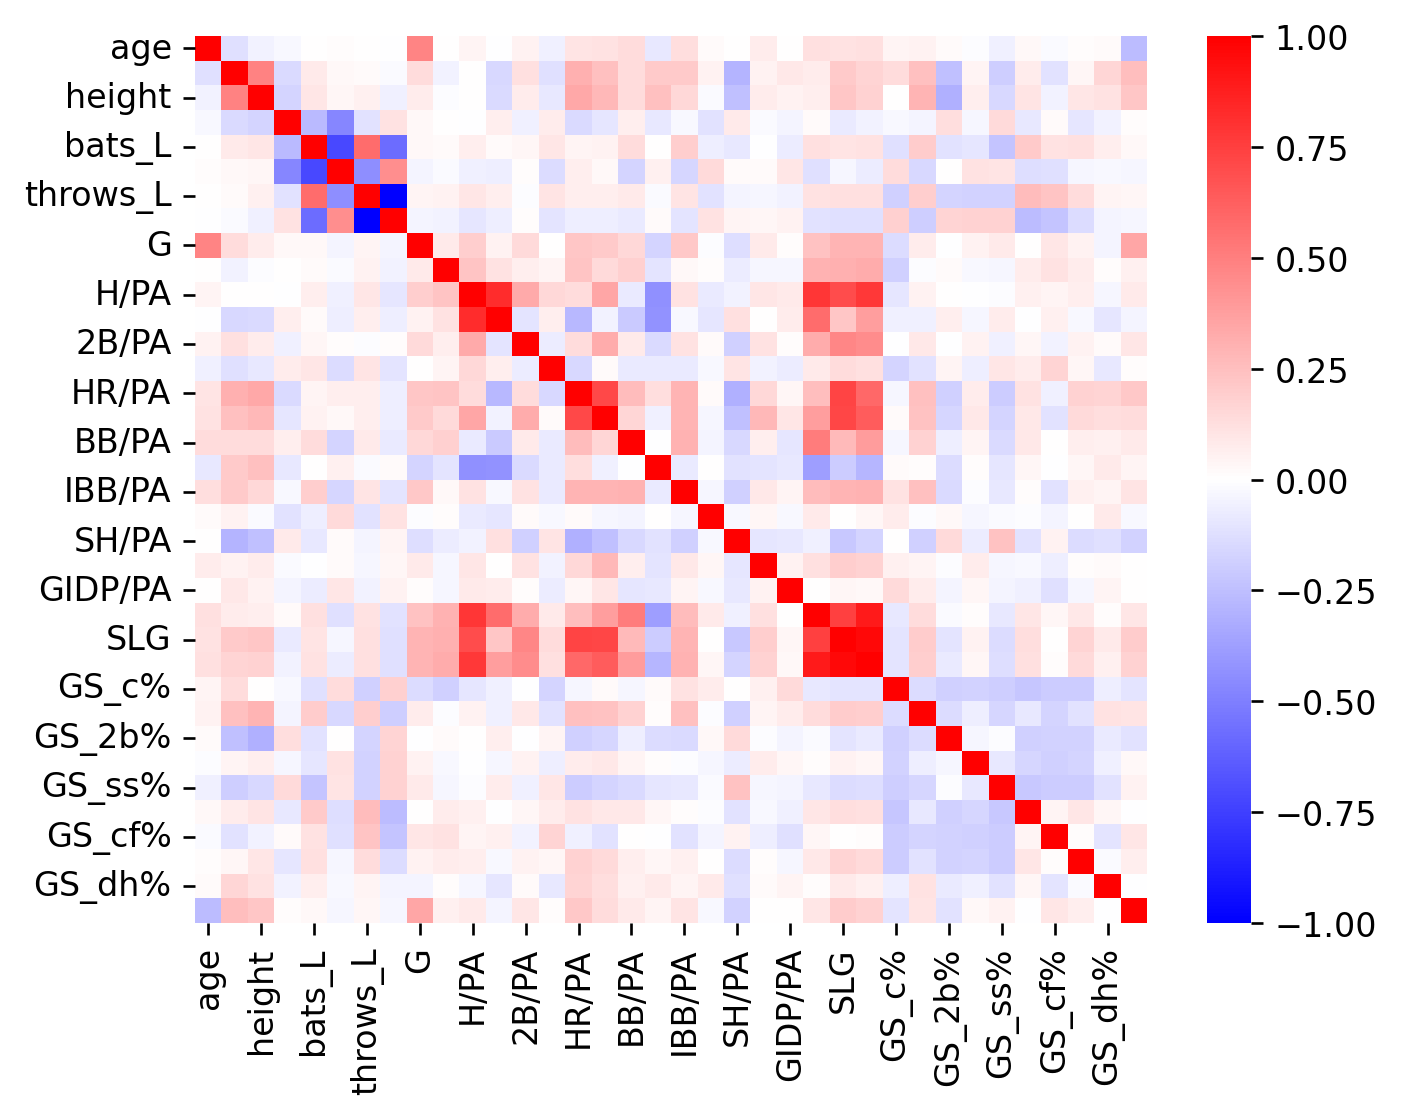

In [ ]:
# plot a heatmap of the correlation between each of the variables
# this is to ensure the model won't face issues due to multicolinearity
sns.heatmap(df.drop('RAR_remaining', axis=1).corr(),vmin=-1,vmax=1,cmap='bwr')
plt.show()

The correlation heatmap showed that, with a few exceptions (OBP, SLG, & OPS as well as handedness), the features were generally uncorrelated. I was satisfied with the state of these feature variables, so I moved on to building and testing the models.



I decided that I would test the following models, as they are some of the most commonly useful for regression:

*   Lasso Regression
*   Ridge Regression
*   Random Forest
*   K-Nearest Neighbors
*   Support Vector Regression
*   Decision Tree

Across all of the models, a random state was applied to ensure consistency of results each time the code is run.





First, I separated the feature variables and target, assigning them as "X" and "y". I then used StandardScaler to scale the features. This was to be used later when applying the optimal model, as I included an option for scaling as part of my user-built K-Fold function.

In [ ]:
# assign the feature variables to 'X' and the target variable to 'y'
X = df.drop('RAR_remaining', axis=1)
y = df['RAR_remaining']

In [ ]:
# scale the feature variables and assign them to 'X_scaled' for use later
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head(5)

,age,weight,height,bats_B,bats_L,bats_R,throws_L,throws_R,G,R/PA,H/PA,1B/PA,2B/PA,3B/PA,HR/PA,RBI/PA,BB/PA,SO/PA,IBB/PA,HBP/PA,SH/PA,SF/PA,GIDP/PA,OBP,SLG,OPS,GS_c%,GS_1b%,GS_2b%,GS_3b%,GS_ss%,GS_lf%,GS_cf%,GS_rf%,GS_dh%,prospect_pts
0,-0.600130,-1.004976,-0.863319,-0.42588,-0.640272,0.894133,-0.40819,0.40819,-0.839133,-0.306455,-0.094798,-0.103931,-0.044375,0.263745,-0.060204,-0.537556,-1.103369,1.182039,-0.461008,0.454178,0.117051,-0.293852,-0.403991,-0.657633,-0.209454,-0.399149,-0.442021,-0.379665,-0.414767,-0.423378,2.856825,-0.513032,-0.460578,-0.462780,-0.351102,-0.737948
1,-0.138837,-1.004976,-0.863319,-0.42588,-0.640272,0.894133,-0.40819,0.40819,-0.422351,-0.089757,-0.133297,-0.290850,-0.271379,0.756307,0.331811,-0.020589,-0.527594,0.954003,0.059572,0.295298,-0.086311,0.241973,-0.427975,-0.382878,0.133547,-0.060952,-0.442021,-0.379665,-0.414767,-0.423378,2.817141,-0.513032,-0.460578,-0.462780,-0.351102,-0.737948
2,0.322456,-1.004976,-0.863319,-0.42588,-0.640272,0.894133,-0.40819,0.40819,-0.043773,-0.182410,-0.120162,-0.343410,-0.111236,1.063564,0.193786,-0.133571,-0.518095,1.101516,-0.085398,0.195758,0.068237,-0.202851,-0.294336,-0.374883,0.139822,-0.053598,-0.442021,-0.379665,-0.198713,-0.069723,2.263946,-0.513032,-0.460578,-0.462780,-0.351102,-0.737948
3,0.783749,-1.004976,-0.863319,-0.42588,-0.640272,0.894133,-0.40819,0.40819,0.282706,-0.132998,-0.030317,-0.282232,0.109039,0.895855,0.121504,-0.116677,-0.580915,1.077023,0.091580,0.057053,0.325567,-0.402671,-0.255625,-0.346412,0.151585,-0.034509,-0.442021,-0.379665,0.152394,-0.100218,1.855007,-0.430757,-0.460578,-0.462780,-0.311729,-0.737948
4,1.245042,-1.004976,-0.863319,-0.42588,-0.640272,0.894133,-0.40819,0.40819,0.550142,-0.121230,-0.014345,-0.267397,0.198184,0.760885,0.093505,-0.097437,-0.594960,1.065146,-0.032918,0.055134,0.258319,-0.187420,-0.190546,-0.345685,0.137572,-0.043626,-0.442021,-0.379665,0.109852,-0.118788,1.820672,-0.369125,-0.460578,-0.432612,-0.228003,-0.737948


The following is my function for performing a K-Fold Cross Validation. It includes an option for standardizing model features, and it returns lists of R-squared values and Mean Squared Errors (MSE) for both Training and Testing sets.

In [ ]:
# create a function to perform K-fold Cross Validation (with option for standardizing features)
def DoKFold(model,X,y,k,standardize=False,random_state=410):
    # import KFold package
    from sklearn.model_selection import KFold
    # if standardize was set to true, import StandardScaler package
    if standardize:
        from sklearn.preprocessing import StandardScaler as SS
        ss = SS()

    # assign kfold function to kf
    kf = KFold(n_splits=k,shuffle=True,random_state=random_state)

    # create empty lists for the training and testing scores and MSE
    train_scores=[]
    test_scores=[]
    train_mse=[]
    test_mse=[]

    # use kfold to split into training and testing data
    for idxTrain,idxTest in kf.split(X):
        Xtrain = X.loc[idxTrain, :]
        Xtest = X.loc[idxTest, :]
        ytrain = y.loc[idxTrain]
        ytest = y.loc[idxTest]

        # standardize features if desired
        if standardize:
            Xtrain = ss.fit_transform(Xtrain)
            Xtest = ss.transform(Xtest)

        # fit the user-provided model
        model.fit(Xtrain,ytrain)

        # append model scores to their respective lists
        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest, ytest))

        # Compute the mean squared errors
        #    and append them to their respective lists
        ytrain_pred = model.predict(Xtrain)
        ytest_pred = model.predict(Xtest)
        train_mse.append(np.mean((ytrain-ytrain_pred)**2))
        test_mse.append(np.mean((ytest-ytest_pred)**2))

    # return the lists
    return train_scores,test_scores,train_mse,test_mse

---
## Lasso Regression

For Lasso Regression, I tested a set of values for the hyperparameter alpha ranging from 0.01 to 1 and utilized a 10-Fold Cross Validation. The optimal hyperparameter was found to be an alpha of 0.33, and the model results were as follows.

In [ ]:
# establish a range of potential alpha values
rng_alpha = np.linspace(0.01, 1, 100)
# set the number of desired k-folds
k = 10

# create empty lists to house the scores and MSEs
avg_tr_score=[]
avg_te_score=[]
avg_tr_mse=[]
avg_te_mse=[]

# for each alpha value
for a in rng_alpha:
    # pass alpha as the model hyperparameter
    las_reg = Lasso(alpha=a)
    # perform k-fold cross validation
    train_scores,test_scores,train_mse,test_mse = DoKFold(las_reg,X,y,k,standardize=True)
    # append scores and MSEs to lists
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))
    avg_tr_mse.append(np.mean(train_mse))
    avg_te_mse.append(np.mean(test_mse))

# find the index of the alpha with the highest testing score
idx = np.argmax(avg_te_score)

# print results for model at the best alpha
print('Optimal alpha value: ' + format(rng_alpha[idx], '.3f'))
print('Training R-squared for this value: ' + format(avg_tr_score[idx],'.3f'))
print('Testing R-squared for this value: ' + format(avg_te_score[idx], '.3f'))
print('Training MSE for this value: ' + format(avg_tr_mse[idx],'.3f'))
print('Testing MSE for this value: ' + format(avg_te_mse[idx], '.3f'))

Optimal alpha value: 0.330
Training R-squared for this value: 0.724
Testing R-squared for this value: 0.717
Training MSE for this value: 3193.093
Testing MSE for this value: 3269.335


---
## Ridge Regression

Similar to Lasso, for Ridge Regression I tested a set of values for the hyperparameter alpha ranging from 0.01 to 1 and utilized a 10-Fold Cross Validation. The optimal hyperparameter was found to be an alpha of 1, and the model results were as follows.

In [ ]:
# establish a range of potential alpha values
rng_alpha = np.linspace(0.01, 1, 100)
# set the number of desired k-folds
k = 10

# create empty lists to house the scores and MSEs
avg_tr_score=[]
avg_te_score=[]
avg_tr_mse=[]
avg_te_mse=[]

# for each alpha value
for a in rng_alpha:
    # pass alpha as the model hyperparameter
    ridge_reg = Ridge(alpha=a)
    # perform k-fold cross validation
    train_scores,test_scores,train_mse,test_mse = DoKFold(ridge_reg,X,y,k,standardize=True)
    # append scores and MSEs to lists
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))
    avg_tr_mse.append(np.mean(train_mse))
    avg_te_mse.append(np.mean(test_mse))

# find the index of the alpha with the highest testing score
idx = np.argmax(avg_te_score)

# print results for model at the best alpha
print('Optimal alpha value: ' + format(rng_alpha[idx], '.3f'))
print('Training R-squared for this value: ' + format(avg_tr_score[idx],'.3f'))
print('Testing R-squared for this value: ' + format(avg_te_score[idx], '.3f'))
print('Training MSE for this value: ' + format(avg_tr_mse[idx],'.3f'))
print('Testing MSE for this value: ' + format(avg_te_mse[idx], '.3f'))

Optimal alpha value: 1.000
Training R-squared for this value: 0.726
Testing R-squared for this value: 0.715
Training MSE for this value: 3173.541
Testing MSE for this value: 3287.587


---
## Random Forest

For the Random Forest model, I tested a range of values for the follow hyperparameters: number of estimators, max depth, and min samples split. I once again utilized my function for performing a 10-fold Cross Validation. The optimal hyperparameters were n_estimators = 200, max_deth = 10, and min_samples_split = 3, and the model results were as follows.

In [ ]:
# establish a range of potential n_estimators, max_depth, and min_samples_split
rng_trees = [10,100,200]
rng_depth = np.arange(2,11)
rng_samples = np.arange(2,11)
# set the number of desired k-folds
k = 10

# create empty list to house results
results = []

# iterate over each combination of hyperparameters
for t in rng_trees:
    for d in rng_depth:
        for s in rng_samples:
            # keep track of the combination of hyperparameters being used
            settings = [t,d,s]
            # establish random forest model with the hyperparameters
            rfr = RFR(random_state=410, n_estimators=t, max_depth = d, min_samples_split=s)
            # perform k-fold cross validation
            tr,te,tr_mse,te_mse = DoKFold(rfr,X,y,k)
            # append model results to results list
            results.append([*settings,tr,te,tr_mse,te_mse])

In [ ]:
# calculate mean test MSE for each hyperparameter combination
mean_test_mse = [np.mean(r[6]) for r in results]
# find the lowest test MSE
min_test_mse = min(mean_test_mse)
# get the index of the results with the lowest test MSE
idx = np.where(mean_test_mse == min_test_mse)
best_results = results[idx[0][0]]
# print the lowest MSE and results
print('Optimal Hyperparameters: ' + str(best_results[0:3]))
print('Avg. Training Score: ' + format(np.mean(best_results[3]),'.3f'))
print('Avg. Testing Score: ' + format(np.mean(best_results[4]), '.3f'))
print('Avg. Training MSE: ' + format(np.mean(best_results[5]),'.3f'))
print('Avg. Testing MSE: ' + format(np.mean(best_results[6]), '.3f'))

Optimal Hyperparameters: [200, 10, 3]
Avg. Training Score: 0.944
Avg. Testing Score: 0.798
Avg. Training MSE: 648.443
Avg. Testing MSE: 2331.823


---
## K-Nearest Neighbors

For the KNN model, the only hyperparameter I sought to optimize was the number of neighbors. A range of values was tested and the optimal number of neighbors was found to be 2. Once again, a 10-fold cross validation was utilized and the results were as follows.

In [ ]:
# establish a range of potential number of neighbors
rng_k = np.arange(2, 30, 1)
# set the number of desired k-folds
folds = 10
# create empty lists to house the scores and MSEs
avg_tr_score=[]
avg_te_score=[]
avg_tr_mse=[]
avg_te_mse=[]

# for each number of neighbors
for k in rng_k:
    # pass the number of neighbors as the model hyperparameter
    knn = KNN(n_neighbors=k)
    # perform k-fold cross validation
    train_scores,test_scores,train_mse,test_mse = DoKFold(knn,X,y,k=folds,standardize=True)
    # append scores and MSEs to lists
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))
    avg_tr_mse.append(np.mean(train_mse))
    avg_te_mse.append(np.mean(test_mse))

# find the index of the alpha with the highest testing score
idx = np.argmax(avg_te_score)

# print results for model at the best number of neighbors
print('Optimal k value: ' + format(rng_k[idx], '.3f'))
print('Training R-squared for this value: ' + format(avg_tr_score[idx],'.3f'))
print('Testing R-squared for this value: ' + format(avg_te_score[idx], '.3f'))
print('Training MSE for this value: ' + format(avg_tr_mse[idx],'.3f'))
print('Testing MSE for this value: ' + format(avg_te_mse[idx], '.3f'))

Optimal k value: 2.000
Training R-squared for this value: 0.936
Testing R-squared for this value: 0.754
Training MSE for this value: 745.902
Testing MSE for this value: 2844.220


---
## Support Vector Regression

Performing a Support Vector Regression only required that I specify what type of kernel I wanted the model to use. In this case, I tested three types of kernels (linear, polynomial, and radially base), with linear perforoming the best out of the three. The model results were as follows.

In [ ]:
# establish kernels to test
kernel_list = ['rbf','linear','poly']
# set the number of desired k-folds
folds = 10

# create empty lists to house the scores and MSEs
avg_tr_score=[]
avg_te_score=[]
avg_tr_mse=[]
avg_te_mse=[]

# for each number of neighbors
for kernel in kernel_list:
    # establish SVR with the given kernel
    svr = SVR(kernel=kernel)
    # perform k-fold cross validation
    train_scores,test_scores,train_mse,test_mse = DoKFold(svr,X,y,k=folds,standardize=True)
    # append scores and MSEs to lists
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))
    avg_tr_mse.append(np.mean(train_mse))
    avg_te_mse.append(np.mean(test_mse))

# find the index of the alpha with the highest testing score
idx = np.argmax(avg_te_score)

# print results for model at the best number of neighbors
print('Optimal kernel: ' + kernel_list[idx])
print('Training score for this value: ' + format(avg_tr_score[idx],'.3f'))
print('Testing score for this value: ' + format(avg_te_score[idx], '.3f'))
print('Training MSE for this value: ' + format(avg_tr_mse[idx],'.3f'))
print('Testing MSE for this value: ' + format(avg_te_mse[idx], '.3f'))

Optimal kernel: linear
Training score for this value: 0.701
Testing score for this value: 0.697
Training MSE for this value: 3462.808
Testing MSE for this value: 3508.034


---
## Decision Tree

The final model I tested was a Decision Tree Regressor. Just as with the Random Forest model, I iterated over a range of hyperparameters for max_depth and min_samples_split. In this case, the optimal values were a max_depth of 6 and min_samples_split of 10. The model results were as follows.

In [ ]:
# establish a range of potential max_depth and min_samples_split
rng_depth = np.arange(2,11)
rng_samples = np.arange(2,11)
# set the number of desired k-folds
k = 10

# create empty list to house results
results = []

# iterate over each combination of hyperparameters
for d in rng_depth:
  for s in rng_samples:
    # keep track of the combination of hyperparameters being used
    settings = [d,s]
    # establish decision tree model with the hyperparameters
    dtr = DTR(random_state=410, max_depth = d, min_samples_split=s)
    # perform k-fold cross validation
    tr,te,tr_mse,te_mse = DoKFold(dtr,X,y,k)
    # append model results to results list
    results.append([*settings,tr,te,tr_mse,te_mse])

In [ ]:
# calculate mean test MSE for each hyperparameter combination
mean_test_mse = [np.mean(r[5]) for r in results]
# find the lowest test MSE
min_test_mse = min(mean_test_mse)
# get the index of the results with the lowest test MSE
idx = np.where(mean_test_mse == min_test_mse)
best_results = results[idx[0][0]]
# print the lowest MSE and results
print('Optimal Hyperparameters: ' + str(best_results[0:2]))
print('Avg. Training Score: ' + format(np.mean(best_results[2]),'.3f'))
print('Avg. Testing Score: ' + format(np.mean(best_results[3]), '.3f'))
print('Avg. Training MSE: ' + format(np.mean(best_results[4]),'.3f'))
print('Avg. Testing MSE: ' + format(np.mean(best_results[5]), '.3f'))

Optimal Hyperparameters: [6, 10]
Avg. Training Score: 0.809
Avg. Testing Score: 0.714
Avg. Training MSE: 2208.206
Avg. Testing MSE: 3325.757


---
## Model Selection

Once optimal hyperparameters were discovered and each of the models were tested, it was time to select the best model for application. The model with the highest testing validity was the Random Forest model with an R-squared of about 0.80, indicating that nearly 80% of all variation in the RAR players produce over the remainder of their career was explained by the model. However, this model had a training validity of 0.94 indicating the model is significantly overfit. The Decision Tree and K-Nearest Neighbors models suffered from the same issue, albeit with a worse validity on both the training and testing sets. With regards to less overfit models, the Support Vector, Lasso, and Ridge regression models performed much better. However, the highest testing validity amongst these three models was the Lasso regression with a Testing R-squared of 0.717.

Deciding which model to proced with required a judgement call. On one hand, I am always eager to utilize the model with the highest testing validity in the hopes of generating the most accurate predictions possible in application. Alternatively, however, an overfit model can have difficulty when applied to new data as it performs much better on the data it already knows, indicating the model may be biased in specific, repeated ways. For the sake of this project, I decided to move forward with the Random Forest model to take advantage of the much higher external validity.

---
## Simplify the Model

Once I had decided what model I wanted to use, it was time to simplify the model by removing any insignificant feature variables. To do this, I looked at the importances ascribed to each of the features by the model. In the case of Random Forest models, the feature importance is determined utilizing the Gini Impurity the model uses when splitting nodes. Features that had a greater effect on reducing this impurity, receive a higher feature importance.

In [ ]:
# establish random forest model with the best hyperparameters
rfr = RFR(n_estimators = 200, max_depth=10, min_samples_split=3, random_state=410)
# fit the model
rfr.fit(X_scaled,y)
# get and sort feature importances
importance = rfr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.65916
Feature: 1, Score: 0.01535
Feature: 2, Score: 0.00515
Feature: 3, Score: 0.00049
Feature: 4, Score: 0.00063
Feature: 5, Score: 0.00080
Feature: 6, Score: 0.00033
Feature: 7, Score: 0.00030
Feature: 8, Score: 0.02341
Feature: 9, Score: 0.00873
Feature: 10, Score: 0.00455
Feature: 11, Score: 0.00618
Feature: 12, Score: 0.00607
Feature: 13, Score: 0.00554
Feature: 14, Score: 0.01574
Feature: 15, Score: 0.01570
Feature: 16, Score: 0.00741
Feature: 17, Score: 0.00779
Feature: 18, Score: 0.00762
Feature: 19, Score: 0.00808
Feature: 20, Score: 0.00804
Feature: 21, Score: 0.00795
Feature: 22, Score: 0.00646
Feature: 23, Score: 0.01070
Feature: 24, Score: 0.02049
Feature: 25, Score: 0.06734
Feature: 26, Score: 0.00079
Feature: 27, Score: 0.00185
Feature: 28, Score: 0.00245
Feature: 29, Score: 0.00529
Feature: 30, Score: 0.00611
Feature: 31, Score: 0.00456
Feature: 32, Score: 0.00264
Feature: 33, Score: 0.00505
Feature: 34, Score: 0.00412
Feature: 35, Score: 0.04714


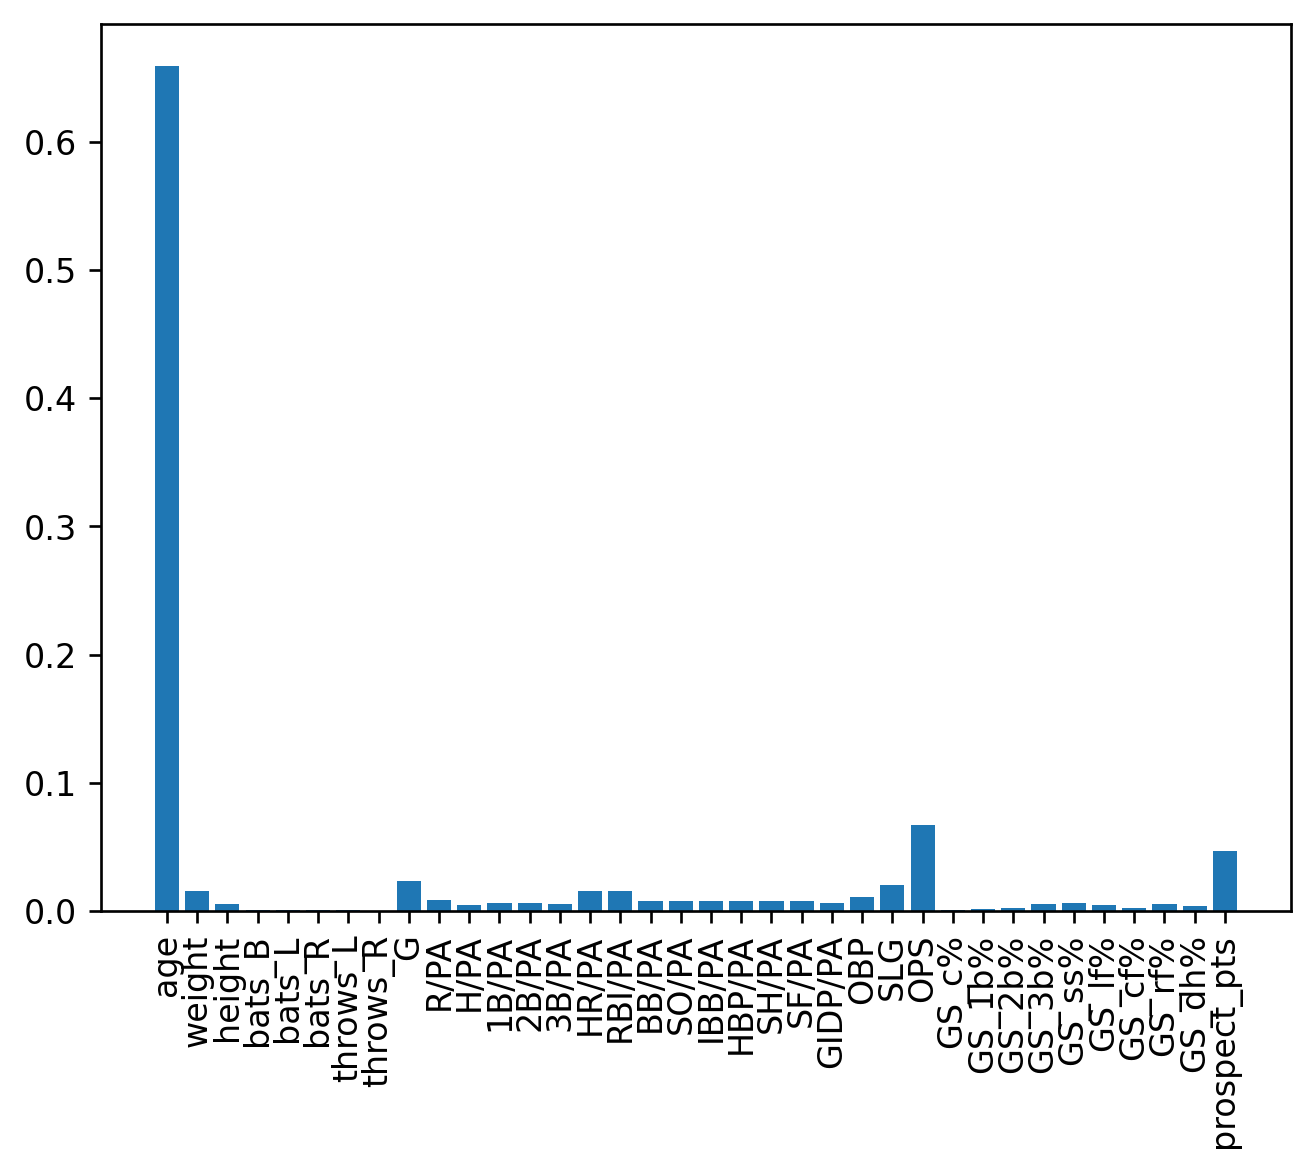

In [ ]:
# plot feature importance
plt.bar([x for x in X.columns], importance)
plt.xticks(rotation=90)
plt.show()

As one would intuitively expect, the most important feature to the model prediction was the players age. It makes sense that when calculating how much production a player has remaining through age 30, it would be most important what age they are currently. In order to get a better idea of the other feature importances, I removed age from the visualization and inspected the others more closely.

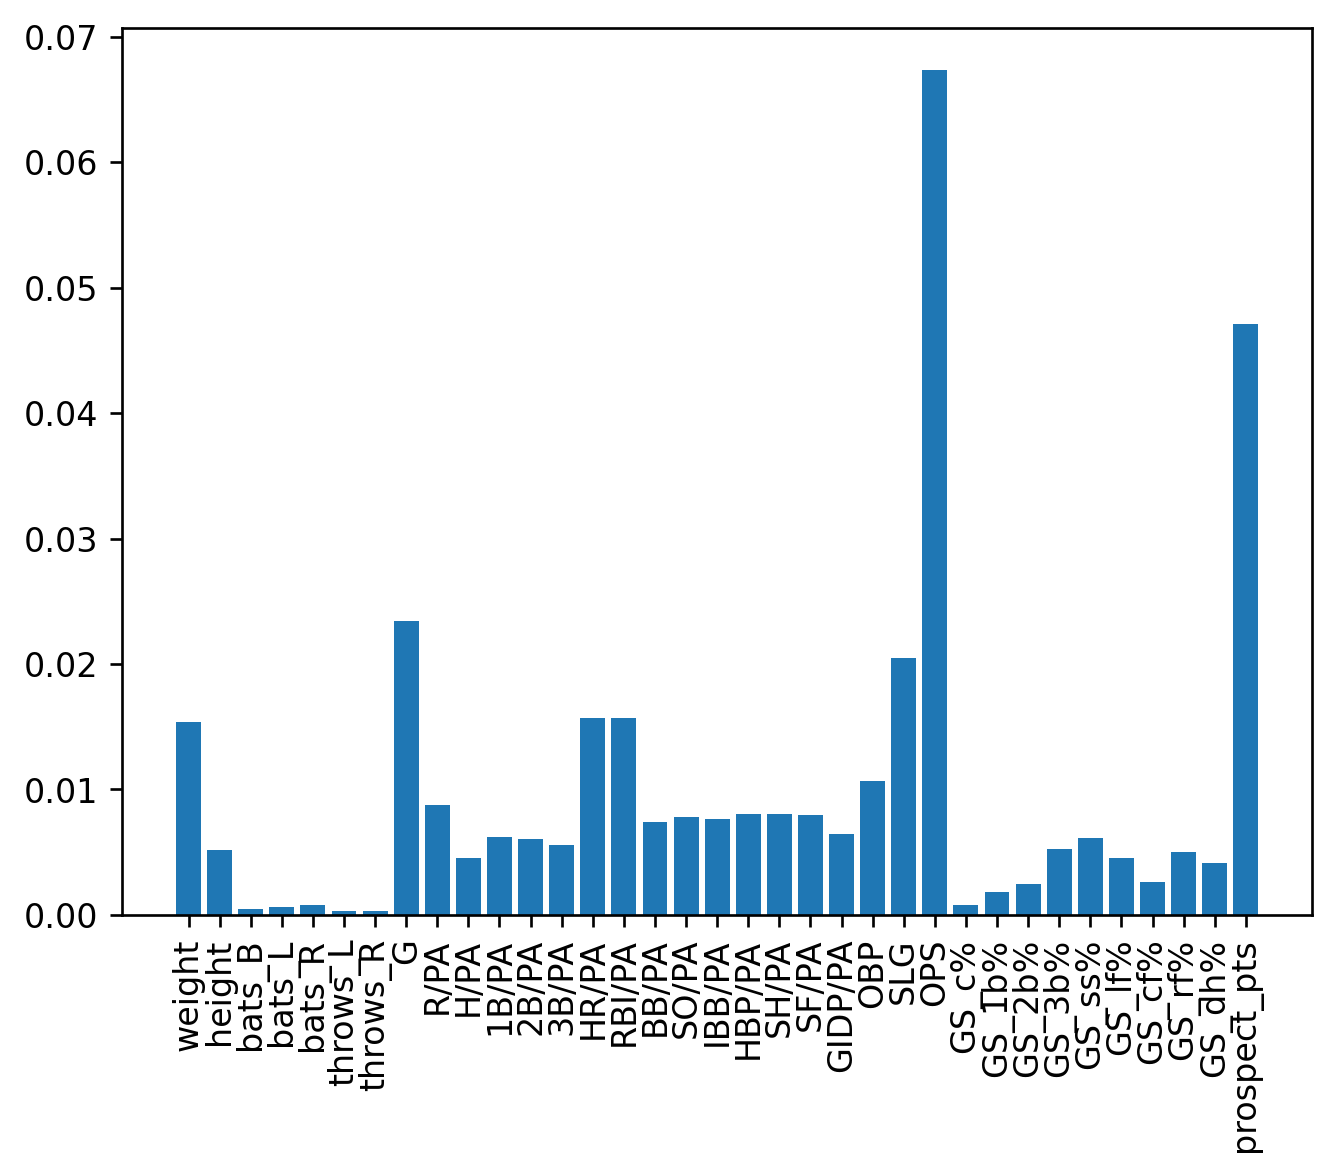

In [ ]:
# plot feature importance
plt.bar([x for x in X.columns[1:36]], importance[1:36])
plt.xticks(rotation=90)
plt.show()

These results indicated that by far the most important feature aside from age was the players career OPS to that point, followed closely by their prospect points. To simplify the model, going forward I only used features with an importance above 0.01. This means that, in addition to those already mentioned, the simplified model included: weight, games played, HR/PA, RBI/PA, OBP, and SLG. It is notable that, though it values certain defensive positions more than others, only offensive metrics were significantly, useful for model predictions.

---
## Establish Best Hyperparameters for Simplified Model

Once more, I tested to find the best hyperparameters for the simplified Random Forest model. I tested a range of values for the hyperparameters n_estimators, max_depth, and min_samples_split. Again I utilized my function for performing a 10-fold Cross Validation, finding optimal hyperparameters of n_estimators = 200, max_deth = 9, and min_samples_split = 3. The model results were as follows.

In [ ]:
# subset features so they only contain the variables with a feature importance above 0.01
X_filtered = X[['age', 'weight', 'G', 'HR/PA', 'RBI/PA', 'OBP', 'SLG', 'OPS', 'prospect_pts']]
X_scaled_filtered = X_scaled[['age', 'weight', 'G', 'HR/PA', 'RBI/PA', 'OBP', 'SLG', 'OPS', 'prospect_pts']]

In [ ]:
# establish a range of potential n_estimators, max_depth, and min_samples_split
rng_trees = [10,100,200]
rng_depth = np.arange(2,11)
rng_samples = np.arange(2,11)
# set the number of desired k-folds
k = 10

# create empty list to house results
results = []

# iterate over each combination of hyperparameters
for t in rng_trees:
    for d in rng_depth:
        for s in rng_samples:
            # keep track of the combination of hyperparameters being used
            settings = [t,d,s]
            # establish random forest model with the hyperparameters
            rfr = RFR(random_state=410, n_estimators=t, max_depth = d, min_samples_split=s)
            # perform k-fold cross validation with only important features
            tr,te,tr_mse,te_mse = DoKFold(rfr,X_filtered,y,k)
            # append model results to results list
            results.append([*settings,tr,te,tr_mse,te_mse])

In [ ]:
# calculate mean test MSE for each hyperparameter combination
mean_test_mse = [np.mean(r[6]) for r in results]
# find the lowest test MSE
min_test_mse = min(mean_test_mse)
# get the index of the results with the lowest test MSE
idx = np.where(mean_test_mse == min_test_mse)
best_results = results[idx[0][0]]
# print the lowest MSE and results
print('Optimal Hyperparameters: ' + str(best_results[0:3]))
print('Avg. Training Score: ' + format(np.mean(best_results[3]),'.3f'))
print('Avg. Testing Score: ' + format(np.mean(best_results[4]), '.3f'))
print('Avg. Training MSE: ' + format(np.mean(best_results[5]),'.3f'))
print('Avg. Testing MSE: ' + format(np.mean(best_results[6]), '.3f'))

Optimal Hyperparameters: [200, 9, 3]
Avg. Training Score: 0.915
Avg. Testing Score: 0.791
Avg. Training MSE: 979.091
Avg. Testing MSE: 2406.840


As we can see, using only the most important features led to a model that was slightly less overfit without sacrificing much predictive accuracy.

---
## Build and Apply Model

Utilizing these optimal hyperparameter values, I then fit the model once more on the scaled and filtered data. The model was then used for prediciting RAR_remaining and a new dataframe was created that includes the year, players' IDs/names, age, RAR remaining, predicted RAR remaining, and the difference between the predicted and actual RAR remaining.

In [ ]:
# establish random forest model with the optimal hyperparameters
rfr = RFR(n_estimators=200, max_depth=9, min_samples_split=3, random_state=410)
# fit the model
rfr.fit(X_scaled_filtered,y)
# calculate predicted values for RAR_remaining
y_pred = rfr.predict(X_scaled_filtered)

# build dataframe containing player IDs, age, year,
#     RAR_remaining, RAR_remaining_pred, and RAR_differential
pred_df = pd.DataFrame(playerIDs)
pred_df['age'] = X['age']
pred_df['year'] = yearIDs
pred_df['RAR_remaining'] = np.round(y,2)
pred_df['RAR_remaining_pred'] = np.round(y_pred,2)
pred_df['RAR_differential'] = np.round(y - y_pred,2)

# merge with People dataset to include first and last name
pred_df = pd.merge(pred_df, ppl_df, how='left', on=['playerID'])
pred_df = pred_df[['playerID', 'nameFirst', 'nameLast', 'year', 'age', 'RAR_remaining', 'RAR_remaining_pred', 'RAR_differential']]

In [ ]:
pred_df.head(5)

,playerID,nameFirst,nameLast,year,age,RAR_remaining,RAR_remaining_pred,RAR_differential
0,abbotku01,Kurt,Abbott,1994,25,136.66,140.92,-4.26
1,abbotku01,Kurt,Abbott,1995,26,100.27,113.44,-13.17
2,abbotku01,Kurt,Abbott,1996,27,73.96,81.27,-7.32
3,abbotku01,Kurt,Abbott,1997,28,48.79,54.94,-6.14
4,abbotku01,Kurt,Abbott,1998,29,25.19,26.10,-0.91


---
## Results

Once a dataframe had been built containing the difference between the actual and predicted RAR remaining, I then sorted the dataframe by this differential. The following two tables show the top 15 players who under and overachieved, respectively, with regards to their RAR remaining.

In [ ]:
# create table of top 15 underachieving athletes
top15_worse_than_pred = pred_df.sort_values('RAR_differential').head(15)
top15_worse_than_pred.reset_index(inplace=True, drop=True)
top15_worse_than_pred

,playerID,nameFirst,nameLast,year,age,RAR_remaining,RAR_remaining_pred,RAR_differential
0,francje02,Jeff,Francoeur,2005,21,179.75,321.10,-141.35
1,kotchca01,Casey,Kotchman,2004,21,175.27,310.70,-135.43
2,francje02,Jeff,Francoeur,2006,22,158.28,293.28,-135.00
3,francje02,Jeff,Francoeur,2007,23,130.84,262.74,-131.90
4,kotchca01,Casey,Kotchman,2005,22,150.54,278.77,-128.23
5,loneyja01,James,Loney,2007,23,178.09,303.19,-125.09
6,kearnau01,Austin,Kearns,2003,23,167.34,292.26,-124.92
7,kotchca01,Casey,Kotchman,2007,24,106.00,218.86,-112.86
8,beckhgo01,Gordon,Beckham,2009,22,174.47,286.96,-112.49
9,kearnau01,Austin,Kearns,2002,22,201.39,312.76,-111.37


Looking at the table of players who underachieved, there are number of names that appear more frequently. For example, three of the top four most underachieving athletes are all Jeff Francoeur (from ages 21 to 23). This makes sense when looking at Francoeur's career as he finished 3rd in Rookie of the Year voting at 21 and was generally a very productive hitter early on before his production declined significantly in later seasons. Additionally, there are a number of players on the list like Casey Kotchman and James Loney who were highly touted prospects but were never fully able to live up to the hype in the majors.

These results are encouraging of the fact that the model is doing a good job of determining which players should have produced more RAR over their career but did not for one reason or another.

In [ ]:
# create table of top 15 overachieving athletes
top15_better_than_pred = pred_df.sort_values('RAR_differential', ascending=False).head(15)
top15_better_than_pred.reset_index(inplace=True, drop=True)
top15_better_than_pred

,playerID,nameFirst,nameLast,year,age,RAR_remaining,RAR_remaining_pred,RAR_differential
0,abreubo01,Bobby,Abreu,1996,22,486.09,321.53,164.56
1,abreubo01,Bobby,Abreu,1997,23,467.42,309.18,158.24
2,rodrial01,Alex,Rodriguez,1995,19,943.23,786.10,157.13
3,guerrvl01,Vladimir,Guerrero,1997,22,586.65,440.29,146.35
4,berkmla01,Lance,Berkman,1999,23,506.79,361.91,144.88
5,heltoto01,Todd,Helton,1997,23,611.58,469.03,142.54
6,blackch02,Charlie,Blackmon,2013,26,264.35,130.05,134.30
7,giambja01,Jason,Giambi,1995,24,401.41,269.44,131.97
8,cabremi01,Miguel,Cabrera,2003,20,785.52,656.26,129.27
9,jonesch06,Chipper,Jones,1995,23,559.64,430.47,129.17


Meanwhile, looking at the overachievers table one more often finds the opposite story. For example, the top two spots were held by age 22 and 23 Bobby Abreu. In his first two seasons, Abreu saw limited playing time and was a consistently below league average hitter. However, at age 24, Abreu became an everyday starter and began a stretch of nearly a dozen years of above average offensive production. Additionally, the third highest player on the list was a 19 year old Alex Rodriguez who only played 48 games and was unproductive at the plate. The following year, however, he finished second in MVP voting and received his first All Star selection. This was just the beginning of an illustrious career that would see 14 more All Stars and 3 MVPs.

As evidenced by these examples, it appears the model also is appropriately failing to predict those players who it should fail to foresee going on to the incredible careers that they had.

Across both of these tables, it is clear that the model has the most difficulty predicting the RAR remaining of younger players, usually between the ages of 19 and 23. It makes intuitive sense that there should be much greater room for prediction error the further removed a player is from his age 30 season. This serves as another indicator that the model  is only having difficulty correctly predicting the values for players where it is supposed to have difficulty.

---
## Conclusion

Optimal results and recommendations for a project like this are not possible without a firm foundation – that is, data that has been evaluated, cleaned, and properly prepared for model fitting. Proper data cleaning and manipulation was a priority in addressing the questions posed in the project. This diligent approach resulted in a model that was optimized for effectiveness and real-world application. The resulting Random Forest model successfully took variables such as age, weight, games played, HR/PA, RBI/PA, OBP, SLG, OPS, and prospect points as features to predict a position player's remaining Runs Above Replacement through their age 30 season. The final model had a Testing R-Squared of nearly 0.80 and Testing MSE of 2046, indicating that a very large percentage of the variation in RAR was explained by the model.

Given my experience with this project, I would be curious in the future to explore other ensemble models that could successfully optimize results. For example, running a Gradient Boosting Regression would help compare the relative effectiveness of boosting and bagging approaches. Additionally, it would be interesting to explore implementing a grid search hyperparameter optimization to improve efficiency over the brute force approach shown above. In data science, there is always room for revisiting both the data and model generation process. Engaging continuous, iterative improvement, together with experiencing practical applications first-hand, is what makes projects such as these so exciting and fulfilling for me.
